In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline
import statsmodels.api as sm
from datetime import timedelta,datetime

# SH and SDS beta calculation and data preparation

In [2]:
df=pd.read_csv("SH_SDS_data.csv",index_col=0)
df.drop(index=[0],inplace=True)  # remove the first row because the time interval btw row 0 and 1 is not 10 seconds
df.reset_index(drop=True,inplace=True)

In [3]:
def calculate_parameters(df):  # calculate in-sample beta, constant
    df['mid1']=(df.bid1+df.ask1)/2
    df['mid2']=(df.bid2+df.ask2)/2
    
    X = sm.add_constant(df.mid2)
    res = sm.OLS(df.mid1, X).fit()
    constant=res.params[0]
    slope=res.params[1]
    
    predicted_Y=constant+slope*df.mid2
    df['residuals']=df.mid1-predicted_Y
    
    return slope, constant


def prep_data(df, slope, constant, res_num, imb1_num, imb2_num):  # symmetrize data and cut states  
    df_flip=df.copy()
    df_flip.columns=['time', 'ask1', 'ask_size1', 'bid1', 'bid_size1', 'ask2', 'ask_size2', 'bid2', 'bid_size2',
                     'mid1','mid2','residuals']
    df_flip[['ask1', 'bid1', 'ask2', 'bid2','residuals']]=-df_flip[['ask1', 'bid1', 'ask2', 'bid2','residuals']]

    change1=df.bid1[len(df)-1]-df_flip.bid1[0]-0.01
    change2=df.bid2[len(df)-1]-df_flip.bid2[0]-0.01

    df_flip[['ask1', 'bid1']]=df_flip[['ask1', 'bid1']]+change1
    df_flip[['ask2', 'bid2']]=df_flip[['ask2', 'bid2']]+change2
    
    df_flip['mid1']=(df_flip.bid1+df_flip.ask1)/2
    df_flip['mid2']=(df_flip.bid2+df_flip.ask2)/2
    predicted_Y_flip=constant+slope*df_flip.mid2

    df_flip.time=pd.to_datetime(df_flip.time)
    df_flip.time+=timedelta(hours=5)
    
    df.set_index("time",inplace=True)
    df.index = pd.to_datetime(df.index,utc=True)
    df2=df[['residuals','mid1','mid2']]
    df2.index = df.index - timedelta(minutes=5)  # data from 5 minutes later
    df2.columns=['residual_later','mid1_later','mid2_later']
    df = pd.merge_asof(df, df2, left_index=True, right_index=True, direction='forward')
    df['pnl'] = df.residual_later-df.residuals  # forward pnl
    df['mid1_diff'] = df.mid1_later-df.mid1
    df['mid2_diff'] = df.mid2_later-df.mid2
    df.dropna(inplace=True)
    
    df_flip.set_index("time",inplace=True)
    df_flip.index = pd.to_datetime(df_flip.index,utc=True)
    df2_flip=df_flip[['residuals','mid1','mid2']]
    df2_flip.index = df_flip.index - timedelta(minutes=5)  # data from 5 minutes later
    df2_flip.columns=['residual_later','mid1_later','mid2_later']
    df_flip = pd.merge_asof(df_flip, df2_flip, left_index=True, right_index=True, direction='forward')
    df_flip['pnl'] = df_flip.residual_later-df_flip.residuals  # forward pnl
    df_flip['mid1_diff'] = df_flip.mid1_later-df_flip.mid1
    df_flip['mid2_diff'] = df_flip.mid2_later-df_flip.mid2
    df_flip.dropna(inplace=True)
    
    df=pd.concat([df,df_flip])

    df.index = pd.to_datetime(df.index,utc=True)
    
    df['residual_bucket'] = pd.cut(df['residuals'], res_num, labels=False)
    
    df['imb1']=df.bid_size1/(df.bid_size1+df.ask_size1)
    df['imb2']=df.bid_size2/(df.bid_size2+df.ask_size2)
    df['imb1_bucket'] = pd.cut(df.imb1, imb1_num, labels=False)
    df['imb2_bucket'] = pd.cut(df.imb2, imb2_num, labels=False)
    return df

In [9]:
res_num=6
imb1_num=3
imb2_num=3

In [4]:
slope, constant=calculate_parameters(df)
df=prep_data(df, slope, constant, res_num, imb1_num, imb2_num)

# Cointegration plot

5-minute interval:
average pnl for 6 residual states are
 residual_bucket
0    0.006524
1    0.004238
2    0.001444
3   -0.001444
4   -0.004238
5   -0.006524
Name: pnl, dtype: float64


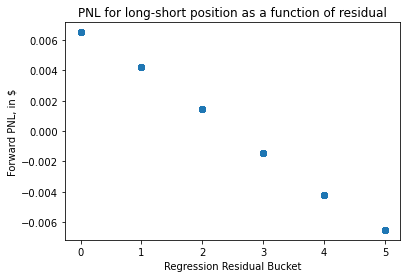

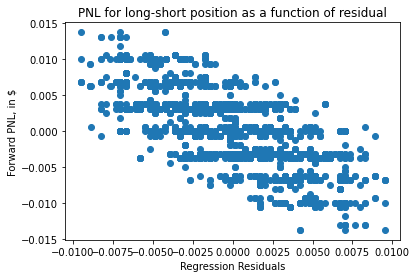

In [10]:
# residual_bucket vs avg_pnl
x1=df.groupby('residual_bucket').pnl.mean()
df=df.assign(avg_pnl=df.residual_bucket.map(x1))

print('5-minute interval:')
print('average pnl for', res_num, 'residual states are\n', x1)
plt.scatter(df.residual_bucket,df.avg_pnl)
plt.xlabel("Regression Residual Bucket")
plt.ylabel('Forward PNL, in $')
plt.title('PNL for long-short position as a function of residual')
plt.xticks(range(0,res_num))
plt.show()

plt.scatter(df.residuals,df.pnl)
plt.xlabel("Regression Residuals")
plt.ylabel('Forward PNL, in $')
plt.title('PNL for long-short position as a function of residual')
plt.show()

# Imbalance plot

5-minute interval:
G1(I_t) for 3 imbalance states are
              mid1_diff
imb1_bucket           
0            -0.004219
1             0.000000
2             0.004219


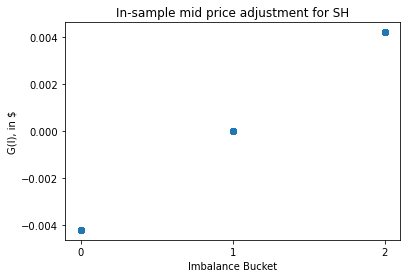

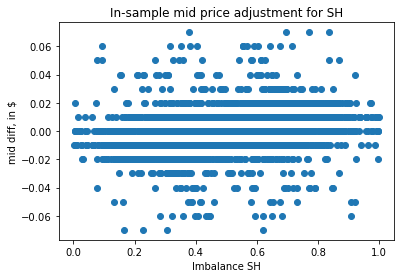

G2(I_t) for 3 imbalance states are
              mid2_diff
imb2_bucket           
0             -0.00437
1              0.00000
2              0.00437


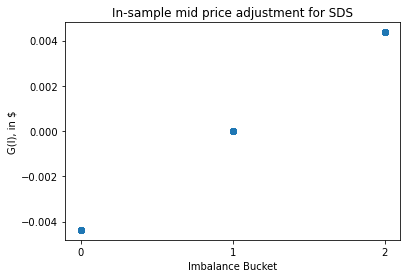

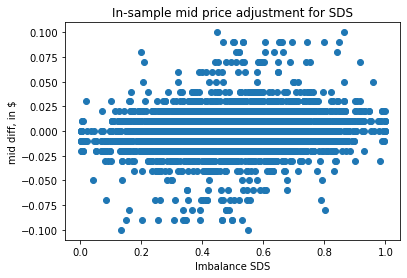

In [14]:
# imb_bucket v.s. G_It
x1=df.groupby('imb1_bucket')[['mid1_diff']].mean()
x2=df.groupby('imb2_bucket')[['mid2_diff']].mean()

df=df.assign(G1_It=df.imb1_bucket.map(x1.mid1_diff),G2_It=df.imb2_bucket.map(x2.mid2_diff))

df.dropna(inplace=True)

print('5-minute interval:')
print('G1(I_t) for',imb1_num,'imbalance states are\n', x1)
plt.scatter(df.imb1_bucket,df.G1_It)
plt.xlabel("Imbalance Bucket")
plt.ylabel('G(I), in $')
plt.title('In-sample mid price adjustment for SH')
plt.xticks(range(0,imb1_num))
plt.show()

plt.scatter(df.imb1,df.mid1_diff)
plt.xlabel("Imbalance SH")
plt.ylabel('mid diff, in $')
plt.title('In-sample mid price adjustment for SH')
plt.show()


print('G2(I_t) for',imb2_num,'imbalance states are\n', x2)
plt.scatter(df.imb2_bucket,df.G2_It)
plt.xlabel("Imbalance Bucket")
plt.ylabel('G(I), in $')
plt.title('In-sample mid price adjustment for SDS')
plt.xticks(range(0,imb2_num))
plt.show()

plt.scatter(df.imb2,df.mid2_diff)
plt.xlabel("Imbalance SDS")
plt.ylabel('mid diff, in $')
plt.title('In-sample mid price adjustment for SDS')
plt.show()

In [16]:
df

,bid1,bid_size1,ask1,ask_size1,bid2,bid_size2,ask2,ask_size2,mid1,mid2,...,mid2_diff,residual_bucket,imb1,imb2,imb1_bucket,imb2_bucket,avg_pnl,G1_It,G2_It,revenue
time,,,,,,,,,,,,,,,,,,,,,
2020-11-23 15:41:49.108311+00:00,18.95,8018,18.96,8288,13.79,2527,13.80,1007,18.955,13.795,...,0.02,3,0.491721,0.715054,1,2,-0.001444,0.000000,0.00437,-0.000161
2020-11-23 15:41:59.133980+00:00,18.96,4966,18.97,12651,13.80,2327,13.81,2096,18.965,13.805,...,0.01,4,0.281887,0.526113,0,1,-0.004238,-0.004219,0.00000,-0.003286
2020-11-23 15:42:09.142515+00:00,18.96,3938,18.97,11870,13.80,2850,13.81,1835,18.965,13.805,...,0.01,4,0.249114,0.608324,0,1,-0.004238,-0.004219,0.00000,-0.003286
2020-11-23 15:42:19.159326+00:00,18.96,7238,18.97,7922,13.81,2320,13.82,2752,18.965,13.815,...,0.00,1,0.477441,0.457413,1,1,0.004238,0.000000,0.00000,0.003589
2020-11-23 15:42:29.175628+00:00,18.96,4987,18.97,11532,13.80,3324,13.81,2013,18.965,13.805,...,0.01,4,0.301895,0.622822,0,1,-0.004238,-0.004219,0.00000,-0.003286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24 01:35:49.115499+00:00,18.95,9945,18.96,3533,13.79,2217,13.80,2124,18.955,13.795,...,-0.01,2,0.737869,0.510712,2,1,0.001444,0.004219,0.00000,0.002039
2020-11-24 01:35:59.136155+00:00,18.95,6098,18.96,7599,13.79,175,13.80,3517,18.955,13.795,...,-0.01,2,0.445207,0.047400,1,0,0.001444,0.000000,-0.00437,0.002039
2020-11-24 01:36:09.155662+00:00,18.95,6994,18.96,7057,13.79,1014,13.80,3394,18.955,13.795,...,-0.01,2,0.497758,0.230036,1,0,0.001444,0.000000,-0.00437,0.002039


In [17]:
df.to_csv('SH_SDS_data_2.csv')